<a href="https://colab.research.google.com/github/Arrizky0911/natural-language-processing-learning/blob/main/Multiclass_Text_Classification_on_Indonesia_Election_Sentiment_Topics_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup Environment**

Importing the libraries needed

In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

Setting up the device for training model

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


load dataset

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
from pathlib import Path

data = Path('/content/drive/My Drive/BDC2024')

# This will prompt for authorization.
drive.mount('/content/drive')

!pwd
print(data)
!ls -lh "drive/My Drive/BDC2024"


Mounted at /content/drive
/content
/content/drive/My Drive/BDC2024
total 1.7M
-rw------- 1 root root 1.4M May 21 10:42 'dataset_penyisihan_bdc_2024(in).csv'
-rw------- 1 root root 304K Jun  7 13:48 'dataset_unlabeled_penyisihan_bdc_2024(in).csv'
-rw------- 1 root root  18K Jun 14 11:39  output_indo_unclean_2_0.5583811246932002.csv


In [ ]:
dataset = pd.read_csv(data/"dataset_penyisihan_bdc_2024(in).csv", sep=";")
dataset.columns = ['text', 'label']
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


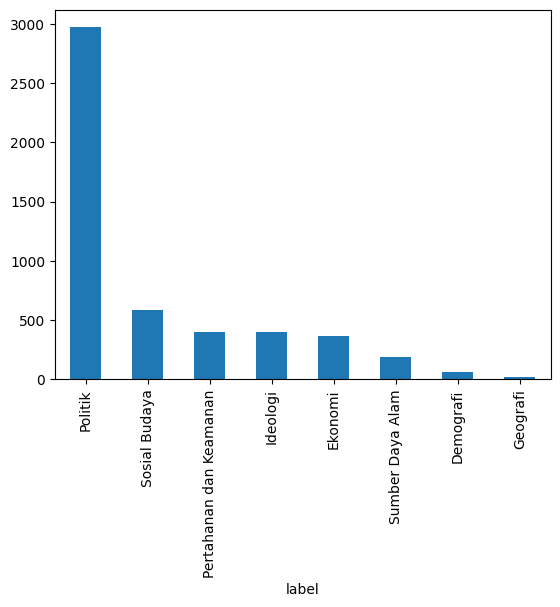

In [ ]:
dataset['label'].value_counts().plot(kind='bar')
plt.show()

# **Preprocessing The Data**

Encode the label category

In [ ]:
# # Converting the codes to appropriate categories using a dictionary
label_mapping = {"Politik": 0, "Sosial Budaya": 1, "Pertahanan dan Keamanan": 2, "Ideologi": 3, "Ekonomi": 4, "Sumber Daya Alam": 5, "Demografi": 6, "Geografi": 7,}
dataset['encode_label'] = dataset['label'].map(label_mapping)

Cleaning the text

In [ ]:
import re
import string

def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\S*@\S*\s?', '', text) # Remove email addresses
    text = re.sub(r'\S*=\S*', '', text) # Remove text that contains an equal sign like picture
    text = re.sub(r'rt\b', '', text) # Remove the word 'rt' for retweet
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters (non-alphanumeric characters)
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces

    return text

In [ ]:
dataset['clean_text'] = dataset['text'].apply(clean_text)

print(dataset['text'].head(15))
print(dataset['clean_text'].head(15))

0     Kunjungan Prabowo ini untuk meresmikan dan men...
1     RT Anies dapat tepuk tangan meriah saat jadi R...
2     @CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...
3     RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...
4     Anies Baswedan Harap ASN termasuk TNI dan Polr...
5     RT Duh jangan sampai Pak lurah denger nih Ã°ÂŸ...
6     Prabowo minta Kemenhan dan Tim Satgas Air Unha...
7     RT Anies: Ya Allah Sibukkanlah Orang Zalim Aga...
8     RT Abah @znOMP7ZMVU9dMuMNA/cIazC9q5+hgwVkTsQNd...
9     RT Bawaslu dimaki "JANCUK" sama warga garaÃ‚Â²...
10    RT Beberapa isu basi terkait @hs5jZceksZrPM0Ni...
11    RT Ganjar Pranowo-Mahfud MD menekankan penting...
12    RT Calon presiden (capres) nomor urut 1 Anies ...
13    Capres Ganjar Pranowo punya rencana besar! Dia...
14    @YcALzIavlM9mN2WtCz3omAmFsnJU8aBm4seMBHJD2vc= ...
Name: text, dtype: object
0     kunjungan prabowo ini untuk meresmikan dan men...
1     anies dapat tepuk tangan meriah saat jadi rekt...
2     emng bener sih p

Defining some key variables that will be used later on in the training

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('cahya/distilbert-base-indonesian')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

Transform the cleaned text dataset

In [ ]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, predict = False):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.predict = predict

    def __getitem__(self, index):
        title = str(self.data.clean_text[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        if self.predict:
          return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
          }
        else:
          return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(mask, dtype=torch.long),
              'targets': torch.tensor(self.data.encode_label[index], dtype=torch.long)
          }


    def __len__(self):
        return self.len

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=200)
test_dataset = dataset.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print(train_dataset.encode_label.value_counts())
print(test_dataset.encode_label.value_counts())


print("FULL Dataset: {}".format(dataset.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

encode_label
0    2383
1     467
3     320
2     319
4     301
5     155
6      41
7      14
Name: count, dtype: int64
encode_label
0    589
1    120
2     81
3     80
4     66
5     37
6     21
7      6
Name: count, dtype: int64
FULL Dataset: (5000, 4)
TRAIN Dataset: (4000, 4)
TEST Dataset: (1000, 4)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }



training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)


# **Training the Transformer Model**

In [ ]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("cahya/distilbert-base-indonesian")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 8)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = DistillBERTClass()
model.to(device)

pytorch_model.bin:   0%|          | 0.00/273M [00:00<?, ?B/s]

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        # When using GPU
        optimizer.step()

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch {epoch}: {epoch_loss}")
    print(f"Training Accuracy Epoch {epoch}: {epoch_accu} \n")

    return

In [ ]:
for epoch in range(0,5):
    train(epoch)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss Epoch 0: 0.9624849725849927
Training Accuracy Epoch 0: 70.7 

Training Loss Epoch 1: 0.6050372453853488
Training Accuracy Epoch 1: 81.925 

Training Loss Epoch 2: 0.40807493614032864
Training Accuracy Epoch 2: 88.425 

Training Loss Epoch 3: 0.27713190900254997
Training Accuracy Epoch 3: 91.825 

Training Loss Epoch 4: 0.18949484815436882
Training Accuracy Epoch 4: 94.475 



In [ ]:
model.eval()
n_correct = 0; n_wrong = 0; total = 0; tr_loss = 0;
nb_tr_steps = 0
nb_tr_examples = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for _, data in enumerate(testing_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask).squeeze()
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        all_preds.extend(big_idx.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

epoch_loss = tr_loss/nb_tr_steps
epoch_accu = (n_correct*100)/nb_tr_examples

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)
balanced_acc = balanced_accuracy_score(all_labels, all_preds)

print(f"Validation Loss Epoch: {epoch_loss}")
print(f"Validation Accuracy Epoch: {epoch_accu}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}\n")
print(f"Balanced Accuracy: {balanced_acc}")
print("Confusion Matrix:")
print(cm)

Validation Loss Epoch: 0.9394416489091236
Validation Accuracy Epoch: 77.2
Validation Precision: 0.7735603889562498
Validation Recall: 0.772
Validation F1 Score: 0.7654774385219517

Balanced Accuracy: 0.5532442505074437
Confusion Matrix:
[[507  27  29   5   9  12   0   0]
 [ 30  75   5   4   1   4   1   0]
 [  5   3  70   2   0   1   0   0]
 [ 25   6   0  47   2   0   0   0]
 [ 11   3   0   0  46   6   0   0]
 [ 10   3   0   0   0  24   0   0]
 [ 10   6   0   1   0   1   3   0]
 [  3   1   0   0   0   2   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
